# Time filter

In [253]:
import time
import numpy as np
import velodyne_decoder as vd
import struct
from scapy.all import rdpcap
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Load .pcap data

In [254]:
pcap_path = '../data/late_z_and_p_test.pcap'
# pcap_path = '../data/zelzah_plummer_intersection_12min_032023_lidar.pcap'

In [255]:
test_cloud_arrays = []
for stamp, points in vd.read_pcap(pcap_path):
    test_cloud_arrays.append(points)

## Look at one frame

In [256]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.'''
    
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, half the max range the 'box size'.
    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [257]:
frame_index = 4  # Index of the frame to plot
test_x = test_cloud_arrays[frame_index][:, 0]
test_y = test_cloud_arrays[frame_index][:, 1]
test_z = test_cloud_arrays[frame_index][:, 2]
intensities = test_cloud_arrays[frame_index][:, 3] 

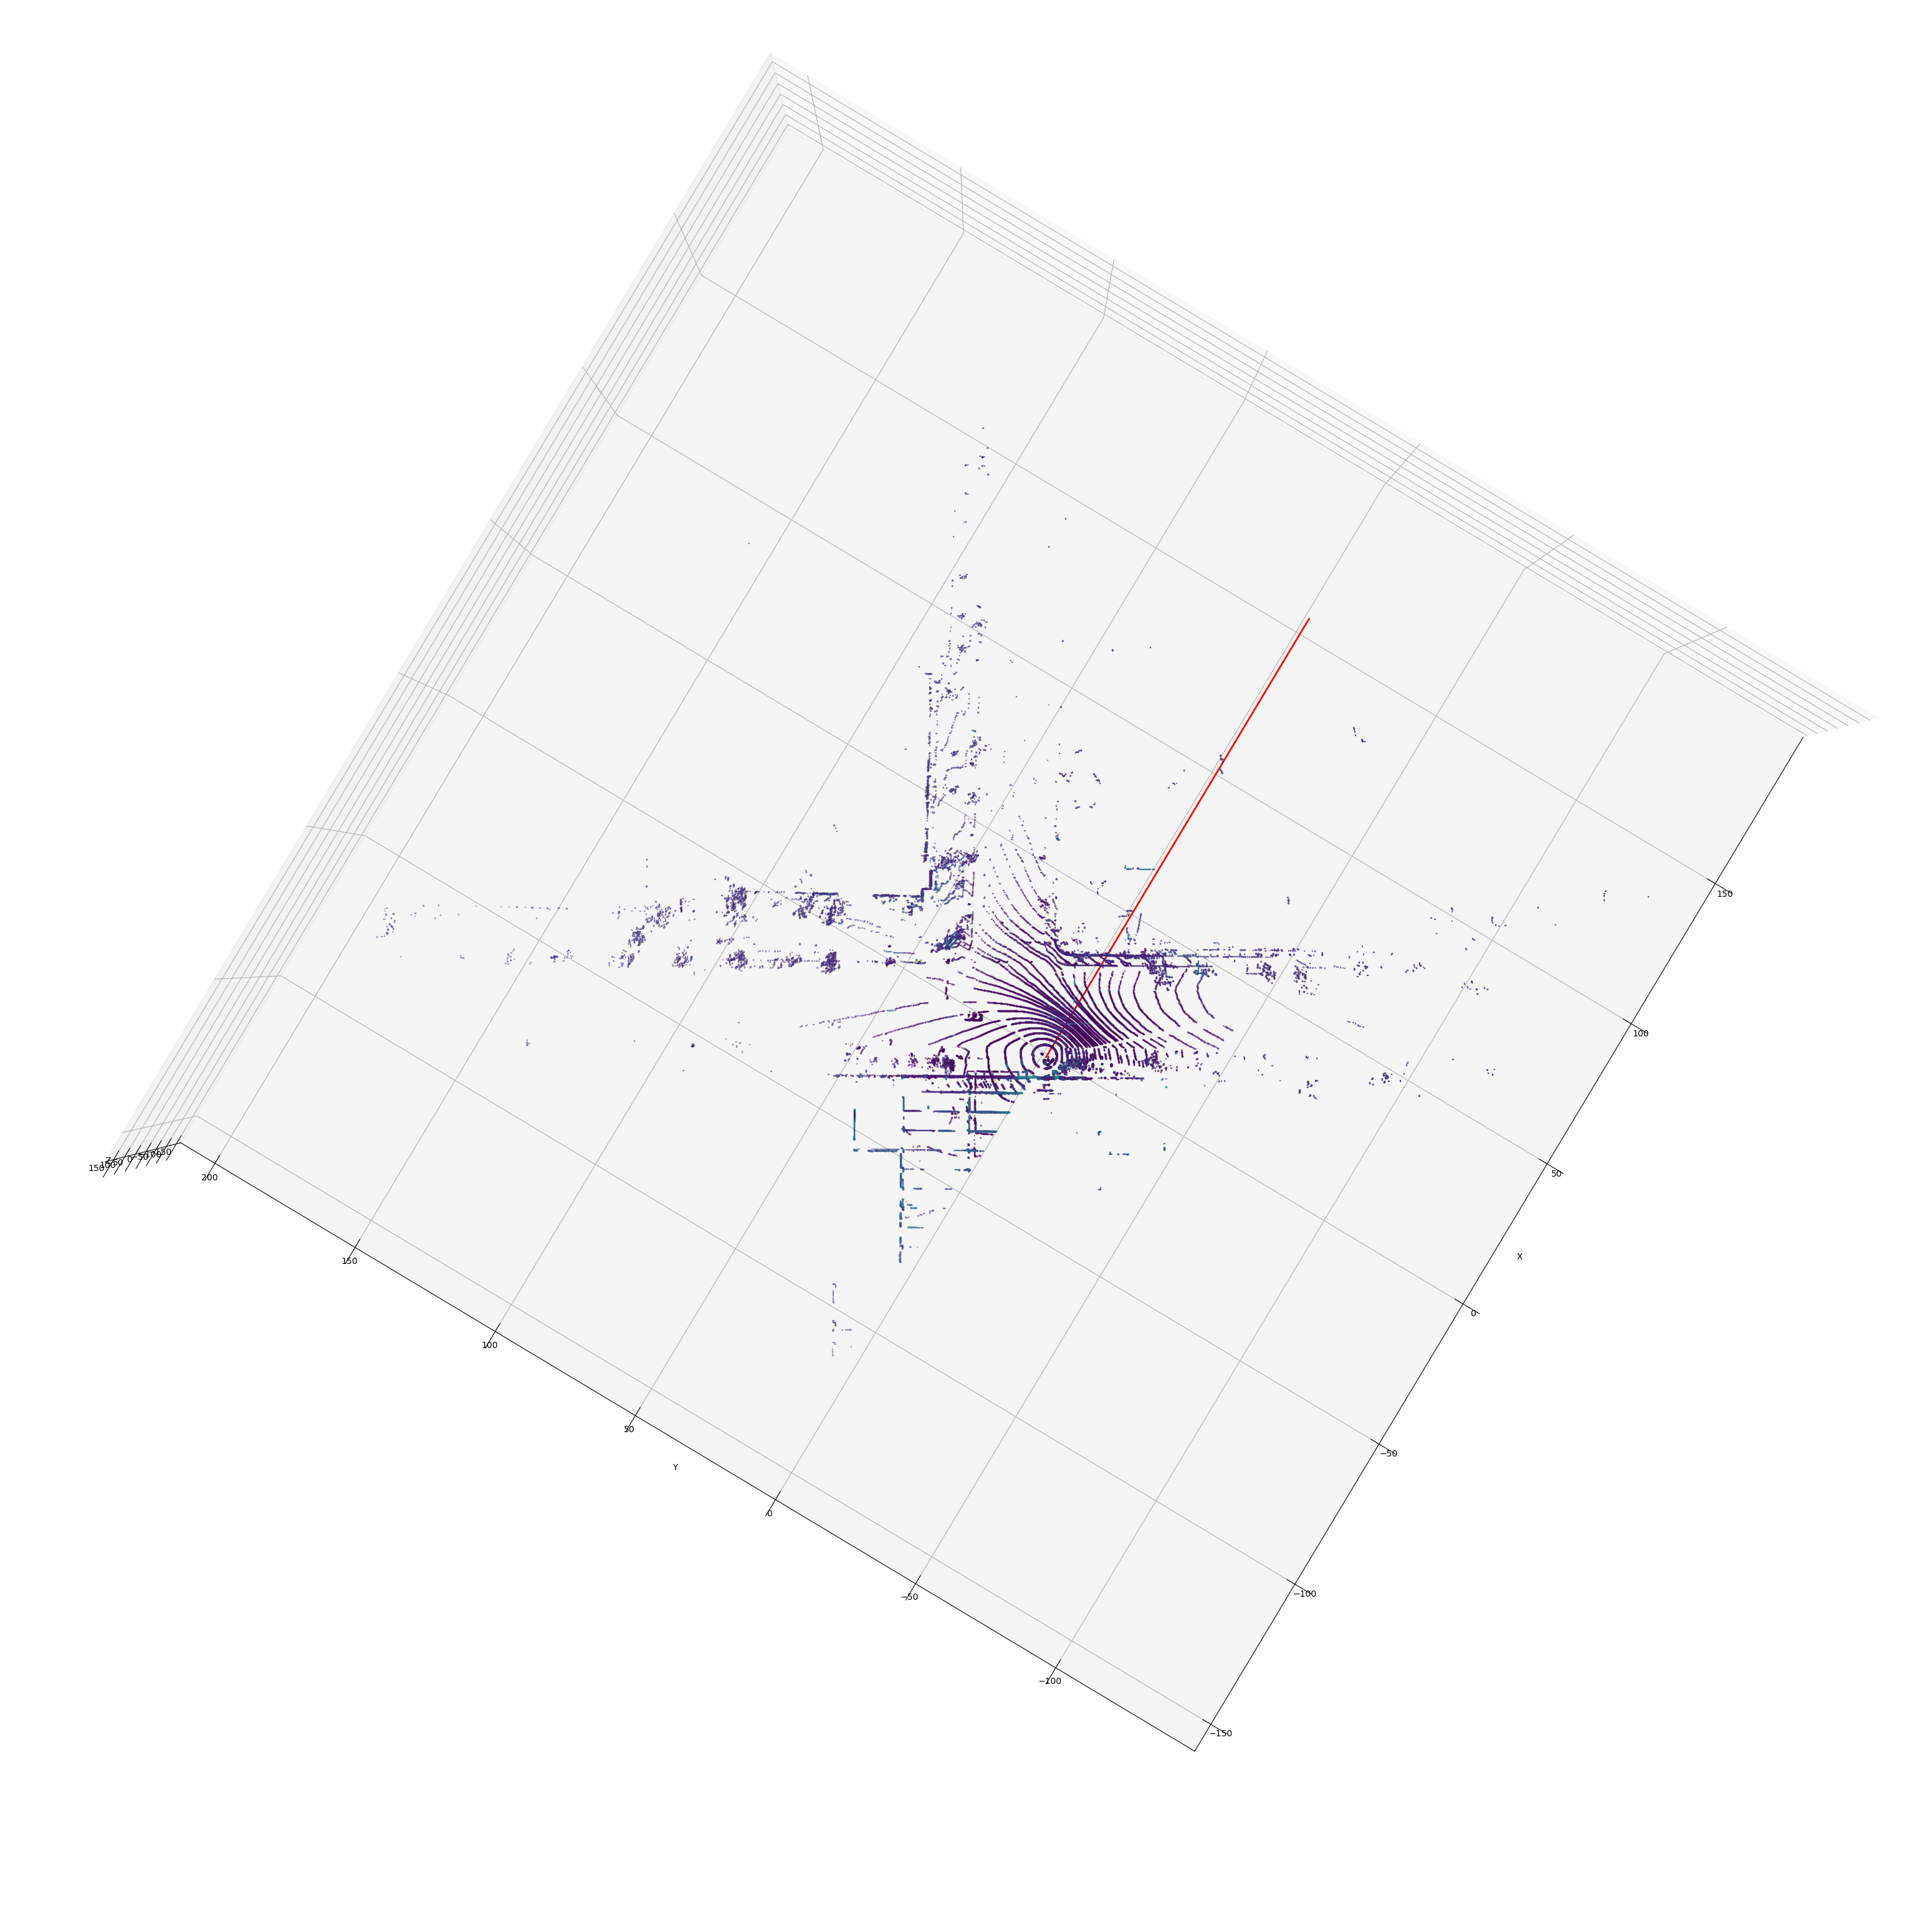

In [258]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(-test_y, test_x, test_z, c=intensities, s=1, cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the line
ax.plot([start_point[0], end_point[0]],  # X coordinates
        [start_point[1], end_point[1]],  # Y coordinates
        [start_point[2], end_point[2]],  # Z coordinates
        color='red', linewidth=2) 

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

## Make filter

In [259]:
# If false, load previously calculated lookup table
make_new_lookup_table = True

In [260]:
# This lookup table is a lot simpler and doesn't need binning
def create_lookup_table():
    num_laser_ids = 32        # Laser IDs from 0 to 31
    num_azimuth_indices = 1824  # These are all of the column values
    # Initialize the lookup table with zeros or any default value
    lookup_table = np.zeros((num_laser_ids, num_azimuth_indices), dtype=np.float32)
    return lookup_table

In [261]:
# def vectorized_update_lookup_table(frame, lookup_table):
#     # Convert points to NumPy arrays
#     laser_ids = np.array([point['laser_id'] for point in frame], dtype=np.int32)
#     azimuth_degs = np.array([point['azimuth'] for point in frame], dtype=np.float32)
#     distances = np.array([point['distance'] for point in frame], dtype=np.float32)
    
#     # Compute azimuth indices
#     azimuth_idxs = np.round(azimuth_degs * 100).astype(np.int32) % 36000
    
#     # Use numpy's indexing to compare and store the larger distances
#     # First, get the current distances from the lookup table
#     current_distances = lookup_table[laser_ids, azimuth_idxs]
    
#     # Create a boolean mask where new distances are greater than current distances
#     mask = distances > current_distances
    
#     # Update the lookup table where the mask is True
#     lookup_table[laser_ids[mask], azimuth_idxs[mask]] = distances[mask]

In [262]:
# For each point, compare to current make and keep the farthest distance
def update_lookup_table(lookup_table, points):
    for point in points:
        laser_id = int(point[6])
        column_id = int(point[5])
        z = point[2]
        # Compare and store the larger distance
        current_z = lookup_table[laser_id, column_id]
        if abs(z) > abs(current_z):
            lookup_table[laser_id, column_id] = z

In [263]:
# def vec_populate_lookup_table(lookup_table, frames):
#     for frame in frames:
#         vectorized_update_lookup_table(frame, lookup_table)
#     return lookup_table

In [264]:
def populate_lookup_table(lookup_table, frames):
    for frame in frames:
        update_lookup_table(lookup_table, frame)
    return lookup_table

In [265]:
distance_lookup_table = create_lookup_table()
populated_lookup_table = populate_lookup_table(distance_lookup_table, test_cloud_arrays[1:-1])

In [266]:
print(populated_lookup_table)

[[-1.525321  -1.525321  -1.5219401 ...  0.         0.         0.       ]
 [-1.4977527 -1.5009876 -1.4988309 ...  0.         0.         0.       ]
 [-1.3855218 -1.3870907 -1.3870907 ...  0.         0.         0.       ]
 ...
 [13.326326  13.811366  13.813804  ...  0.         0.         0.       ]
 [22.967989  23.033995  17.279125  ...  0.         0.         0.       ]
 [21.851604  21.177639  21.23458   ...  0.         0.         0.       ]]


In [267]:
# vec_distance_lookup_table = create_lookup_table()
# vectorized_table = vec_populate_lookup_table(vec_distance_lookup_table, test_frames[1:-1])

In [268]:
# print(vectorized_table)

In [269]:
populated_lookup_table.shape

(32, 1824)

In [270]:
# Check if each column is all zeros
empty_columns = np.all(populated_lookup_table == 0, axis=0)

num_zero_cols = 0
num_populated_cols = 0
empty_col_indices = []

# Print results
for i, is_empty in enumerate(empty_columns):
    if is_empty:
        num_zero_cols += 1
        empty_col_indices.append(i)
    else:
        num_populated_cols += 1
        
print(f"{num_zero_cols} Columns contains only zero values.")
print(f"{num_populated_cols} Columns contains non-zero values.")
if len(empty_col_indices) < 50:
    print(empty_col_indices)

12 Columns contains only zero values.
1812 Columns contains non-zero values.
[1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823]


## Test filter on frame

In [301]:
x_idx = 0
y_idx = 1
z_idx = 2
intensity_idx = 3
column_idx = 5
ring_idx = 6

# Take one frame
test_frame = test_cloud_arrays[4]
test_frame_2 = test_cloud_arrays[5]
print(len(test_frame))

from_col = 900
to_col = 901

filtered_frame = []
# For each point in that frame
for point in test_frame:
    # Find the distance at the column, ring indices
    background_z = populated_lookup_table[int(point[ring_idx])][int(point[column_idx])]
    # Get distance for point
    z = point[z_idx]
#     distance = np.sqrt(point[x_idx]**2 + point[y_idx]**2 + point[z_idx]**2)
#     print(distance)
#     print(background_distance)
    # Compare to distance in map
    if abs(background_z) - abs(z) > 0.05:
        # save if the point is closer
        filtered_frame.append([point[x_idx], point[y_idx], point[z_idx], point[intensity_idx]])
        
# for point in test_frame_2:
#     # Find the distance at the column, ring indices
#     background_distance = populated_lookup_table[int(point[ring_idx])][int(point[column_idx])]
#     # Get distance for point
#     distance = np.sqrt(point[x_idx]**2 + point[y_idx]**2 + point[z_idx]**2)
# #     print(distance)
# #     print(background_distance)
#     # Compare to distance in map
#     if distance < background_distance and point[column_idx] > from_col and point[column_idx] <= to_col:
#         # save if the point is closer
#         filtered_frame.append([point[x_idx], point[y_idx], point[z_idx], point[intensity_idx]])

# Create a DataFrame from the list of points
points_df = pd.DataFrame(filtered_frame, columns=['x', 'y', 'z', 'intensity'])

52631


In [302]:
print(len(points_df))

32186


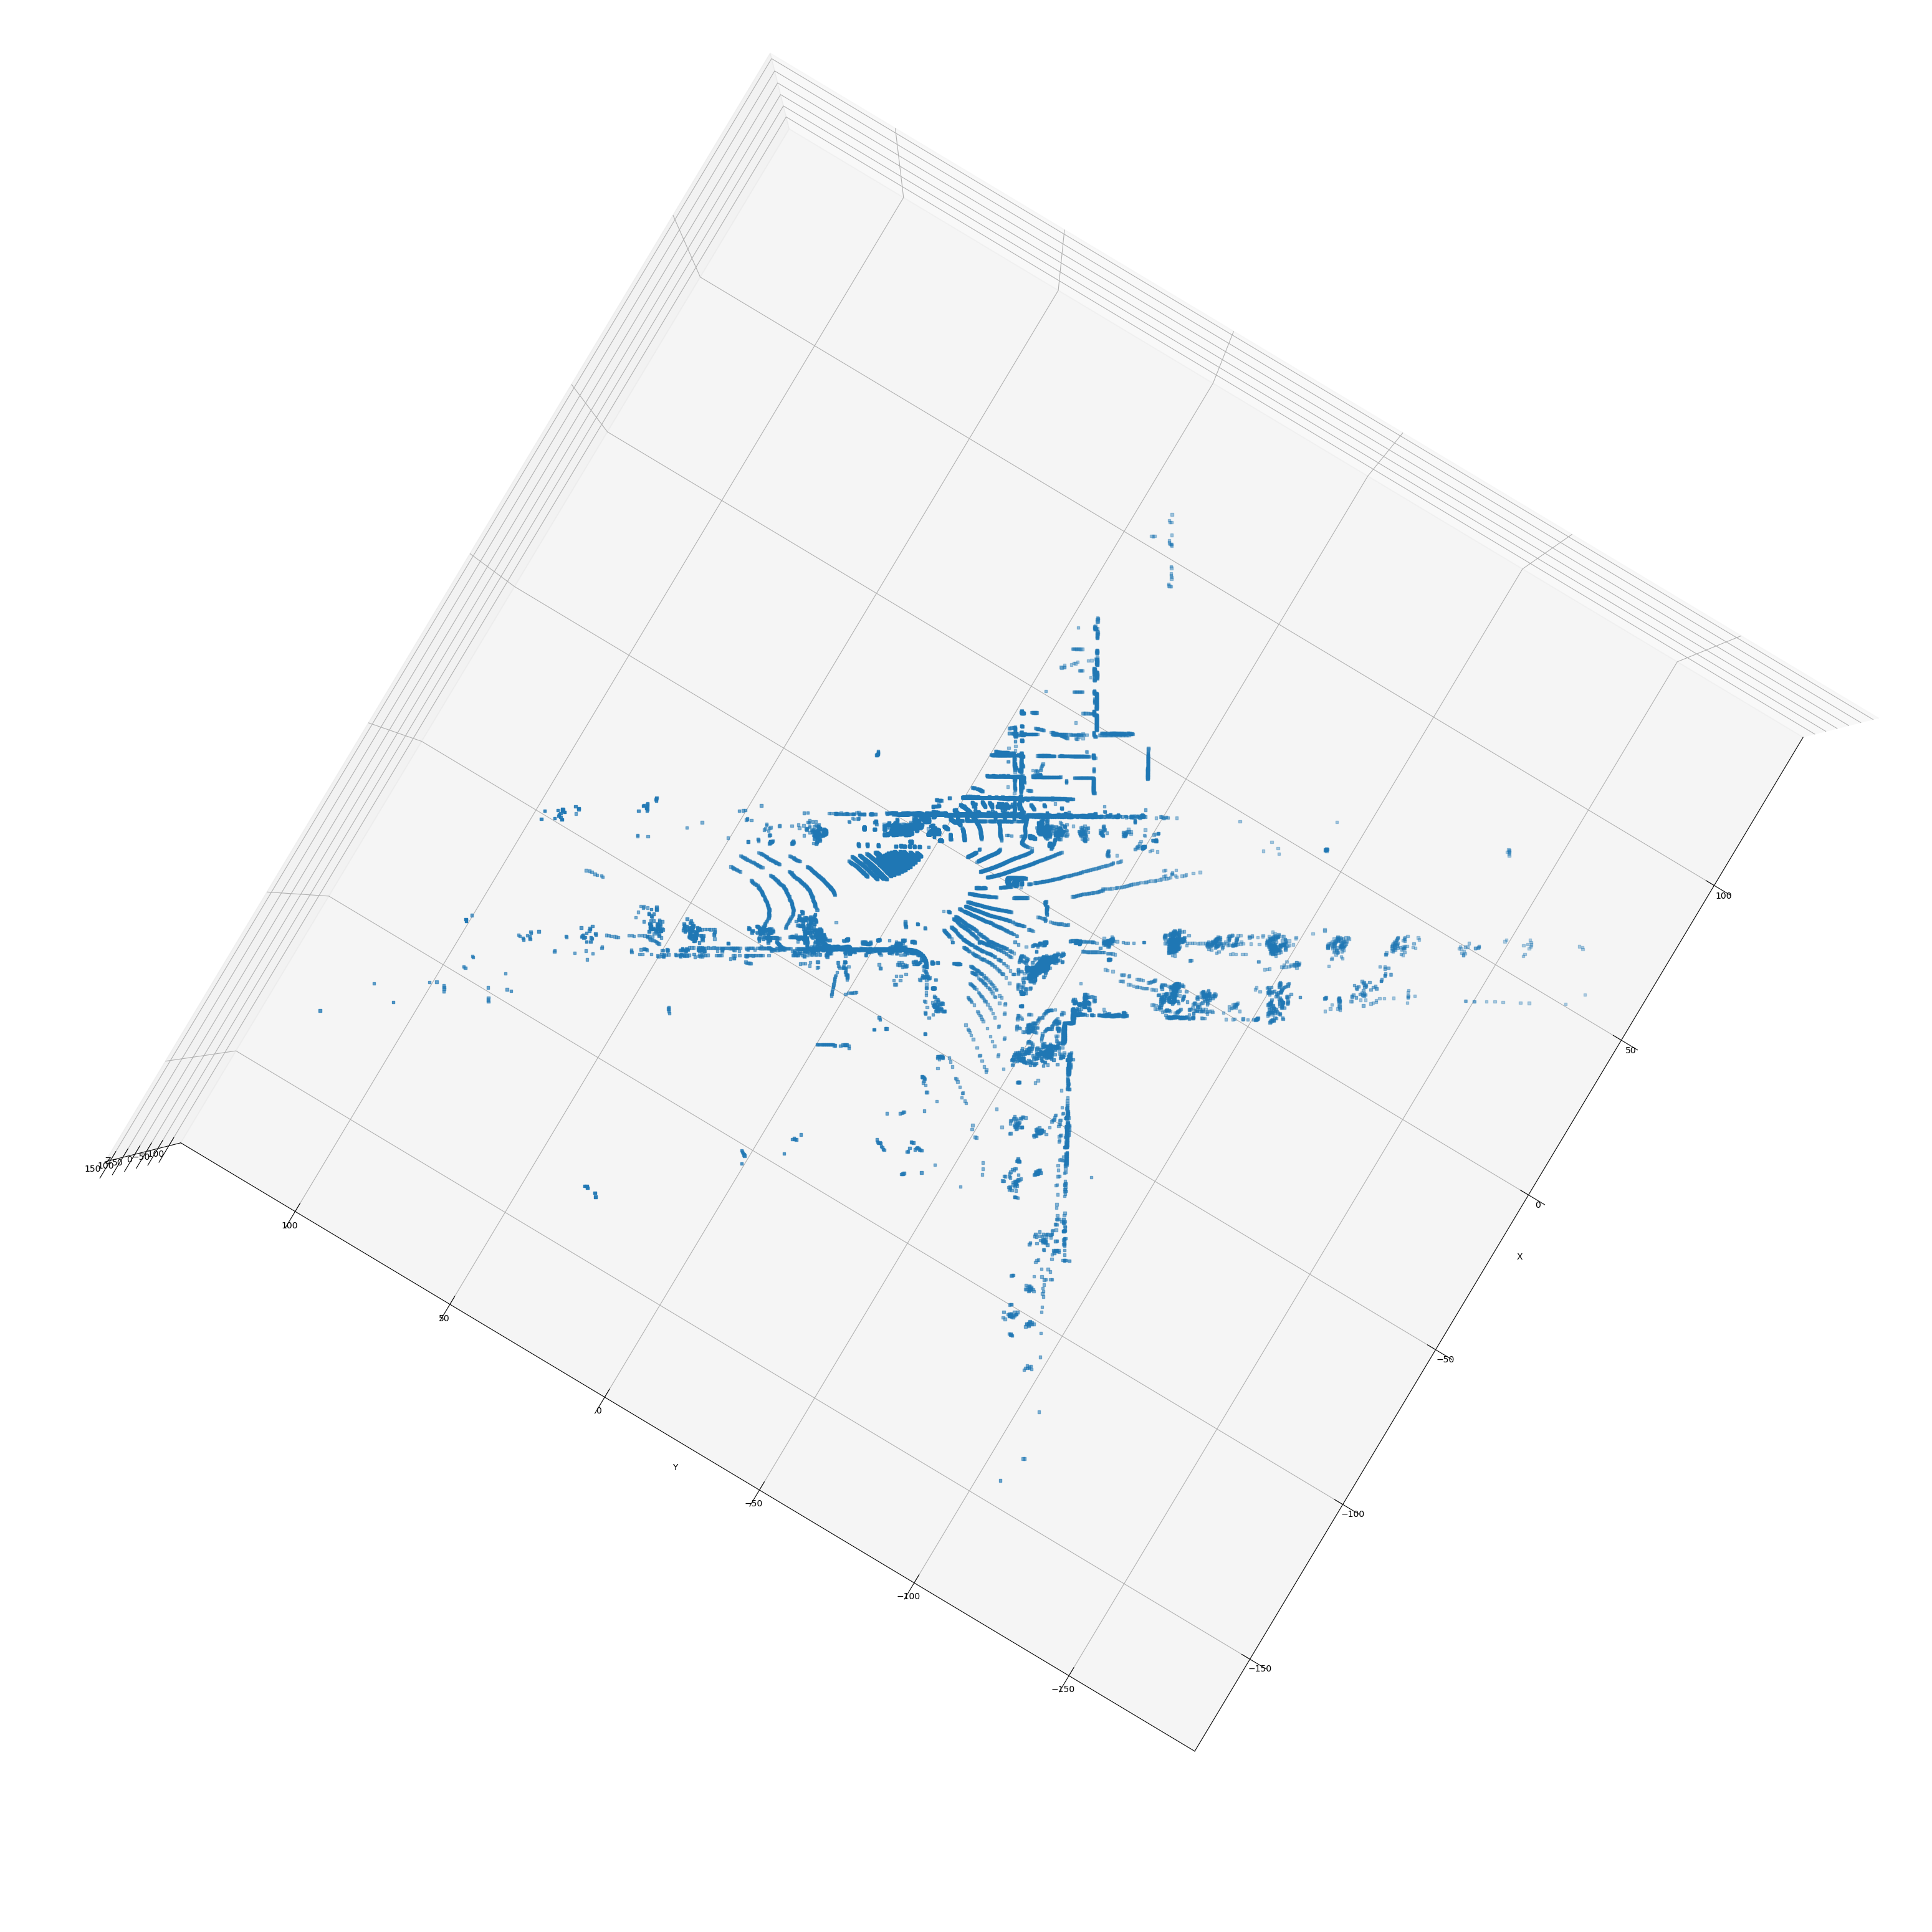

In [303]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points_df['y'], -points_df['x'], points_df['z'], s=10, marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

## Look at filter

In [274]:
# # Number of valid columns (excluding the last 12 empty ones)
# num_columns = 1812

In [275]:
# Angle increment per column in radians
angle_increment_deg = 360 / num_columns

# Azimuth angles for each column
azimuth_angles_deg = np.arange(num_columns) * angle_increment_deg
print(azimuth_angles_deg[-10:])

[358.01324503 358.21192053 358.41059603 358.60927152 358.80794702
 359.00662252 359.20529801 359.40397351 359.60264901 359.8013245 ]


In [276]:
# Angle increment per column in radians
angle_increment_rad = 2 * np.pi / num_columns

# Azimuth angles for each column in radians
azimuth_angles_rad = np.arange(num_columns) * angle_increment_rad
print(azimuth_angles_rad[-10:])
print(len(azimuth_angles_rad))

[6.24850989 6.25197743 6.25544497 6.25891252 6.26238006 6.2658476
 6.26931514 6.27278268 6.27625022 6.27971777]
1812


In [277]:
# # Laser ID mapping for VLP-32C
# laser_id_mapping = np.array([
#     15, 14, 13, 12, 11, 10, 9, 8,
#     7, 6, 5, 4, 3, 2, 1, 0,
#     31, 30, 29, 28, 27, 26, 25, 24,
#     23, 22, 21, 20, 19, 18, 17, 16
# ])

In [278]:
# raw_calib_data = [
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -25},
#     {'rot_corr_deg': 4.2, 'vert_corr_deg': -1},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -1.667},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -15.639},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -11.31},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': 0},
#     {'rot_corr_deg': -4.2, 'vert_corr_deg': -0.667},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -8.843},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -7.254},
#     {'rot_corr_deg': 4.2, 'vert_corr_deg': 0.333},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -0.333},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -6.148},
#     {'rot_corr_deg': -4.2, 'vert_corr_deg': -5.333},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': 1.333},
#     {'rot_corr_deg': -4.2, 'vert_corr_deg': 0.667},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -4},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -4.667},
#     {'rot_corr_deg': 4.2, 'vert_corr_deg': 1.667},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': 1},
#     {'rot_corr_deg': 4.2, 'vert_corr_deg': -3.667},
#     {'rot_corr_deg': -4.2, 'vert_corr_deg': -3.333},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': 3.333},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': 2.333},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -2.667},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': -3},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': 7},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': 4.667},
#     {'rot_corr_deg': 4.2, 'vert_corr_deg': -2.333},
#     {'rot_corr_deg': -4.2, 'vert_corr_deg': -2},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': 15},
#     {'rot_corr_deg': -1.4, 'vert_corr_deg': 10.333},
#     {'rot_corr_deg': 1.4, 'vert_corr_deg': -1.333},
# ]

In [279]:
# background_points = []

# # For each column in the background map
# for laser_idx, laser_distance_values in enumerate(populated_lookup_table):
#     # For each row in the background map
#     for col_idx, distance in enumerate(populated_lookup_table[laser_idx]):  
        
#         if distance > 0:  # Only process positive distances
#             azimuth_angle_deg = azimuth_angles_deg[col_idx]
#             corrected_azimuth_angle_deg = azimuth_angle_deg + raw_calib_data[laser_id_mapping[laser_idx]]['rot_corr_deg']
#             azimuth_angle_rad = np.deg2rad(corrected_azimuth_angle_deg)
#             elevation_angle_deg = raw_calib_data[laser_id_mapping[laser_idx]]['vert_corr_deg']
#             elevation_angle_rad = np.deg2rad(elevation_angle_deg)

#             # Convert to Cartesian coordinates
#             x = distance * np.cos(elevation_angle_rad) * np.sin(azimuth_angle_rad)
#             y = distance * np.cos(elevation_angle_rad) * np.cos(azimuth_angle_rad)
#             z = distance * np.sin(elevation_angle_rad)

#             # Append the coordinates to the list
#             background_points.append([x, y, z])

# # Create a DataFrame from the list of points
# points_df = pd.DataFrame(background_points, columns=['x', 'y', 'z'])

# # azimuth_rad = np.deg2rad(azimuth)
# # height_rad = np.deg2rad(height)
# # x = distance * np.cos(height_rad) * np.sin(azimuth_rad)
# # y = distance * np.cos(height_rad) * np.cos(azimuth_rad)
# # z = distance * np.sin(height_rad)

# # # Stack the computed values into a numpy array
# # xyz_intensity_array = np.column_stack((x, y, z, intensity))

# # return xyz_intensity_array

# # If this doesn't work, try to get the mapping, then the angle from the map

In [280]:
# points_df.head()

In [281]:
# # Set up the plot
# fig = plt.figure(figsize=(40, 40))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the point cloud
# ax.scatter(points_df['y'], -points_df['x'], points_df['z'], s=10, marker=',')

# # Setting the axes properties
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # Adjust the view angle if needed
# ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# # Fix aspect ratio
# set_axes_equal(ax)

# plt.show()

In [282]:
# focal_distance = 42.4e-3

In [283]:
# laser_corrections = []

# for i, calib in enumerate(raw_calib_data):
#     rot_corr_deg = calib['rot_corr_deg']
#     vert_corr_deg = calib['vert_corr_deg']
#     rot_correction = np.deg2rad(rot_corr_deg)
#     vert_correction = np.deg2rad(vert_corr_deg)
#     # Compute vertical offset correction
#     vert_offset_correction = focal_distance * np.tan(-vert_correction)
#     laser_corrections.append({
#         'laser_idx': i,
#         'rot_correction': rot_correction,
#         'vert_correction': vert_correction,
#         'vert_offset_correction': vert_offset_correction
#     })
    
# for corr in laser_corrections:
#     print(corr)

In [284]:
# # Create a mapping from laser_idx to corrections
# laser_correction_map = {corr['laser_idx']: corr for corr in laser_corrections}
# print(laser_correction_map[list(laser_correction_map)[0]])

In [285]:
# # Arrays to hold vertical corrections and offsets for each laser
# vert_corrections = np.array([laser_correction_map[i]['vert_correction'] for i in range(32)])
# vert_offset_corrections = np.array([laser_correction_map[i]['vert_offset_correction'] for i in range(32)])
# print(vert_corrections)

In [286]:
# # Background map: a 32x1824 array (numpy array)
# # Let's trim it to the valid columns
# background_map = populated_lookup_table[:, :num_columns]  # Shape: (32, 1812)

# # Initialize arrays to hold the coordinates
# x_coords = np.zeros((32, num_columns))
# y_coords = np.zeros((32, num_columns))
# z_coords = np.zeros((32, num_columns))

# # Loop over each laser (row)
# for laser_idx in range(32):
#     # Get the distance measurements for this laser
#     distances = background_map[laser_idx, :]  # Shape: (num_columns,)

#     # Get the vertical correction for this laser
#     vert_correction = vert_corrections[laser_idx]
#     vert_offset = vert_offset_corrections[laser_idx]
    
#     # Get the rotational correction for this laser
#     rot_correction = laser_correction_map[laser_idx]['rot_correction']
    
#     # Apply rotational correction to azimuth angles
#     corrected_azimuth = azimuth_angles + rot_correction
    
#     # Compute x, y, z coordinates
#     x = distances * np.cos(vert_correction) * np.sin(corrected_azimuth)
#     y = distances * np.cos(vert_correction) * np.cos(corrected_azimuth)
#     z = distances * np.sin(vert_correction) + vert_offset
    
#     # Store the coordinates
#     x_coords[laser_idx, :] = x
#     y_coords[laser_idx, :] = y
#     z_coords[laser_idx, :] = z

In [287]:
# # Create a mask for valid distances
# valid_mask = background_map > 0

# # Flatten the arrays and apply the mask
# x_valid = x_coords[valid_mask]
# y_valid = y_coords[valid_mask]
# z_valid = z_coords[valid_mask]

In [288]:
# # Stack the coordinates into a point cloud array
# background_point_cloud = np.vstack((x_valid, y_valid, z_valid)).T  # Shape: (num_points, 3)

In [289]:
# # Create a 3D scatter plot
# fig = plt.figure(figsize=(40, 40))
# ax = fig.add_subplot(111, projection='3d')

# # Plot a subset if there are too many points
# num_points_limit = 100000
# if len(x_valid) > num_points_limit:
#     idx = np.random.choice(len(x_valid), size=num_points_limit, replace=False)
#     ax.scatter(x_valid[idx], y_valid[idx], z_valid[idx], s=0.1, marker=',')
# else:
#     ax.scatter(x_valid, y_valid, z_valid, s=0.1, marker=',')
    
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title('LiDAR Point Cloud Visualization')

# # Adjust the view angle if needed
# ax.view_init(elev=90, azim=210)

# # Fix aspect ratio
# set_axes_equal(ax)

# plt.show()

In [290]:
# # Convert filter to x, y, x, intensity
# vertical_angles = np.array([correction['vert_correction'] for correction in laser_corrections])  # Shape: (32,)
# vertical_angles = vertical_angles.reshape(32, 1)
# print(vertical_angles)

In [291]:
# # Create an array of azimuth indices from 0 to 35999
# azimuth_indices = np.arange(36000)  # Shape: (36000,)

# # Compute azimuth angles in degrees
# azimuth_degrees = azimuth_indices / 100.0  # From 0.00 to 359.99 degrees

# # Convert azimuth angles to radians
# azimuth_angles = np.deg2rad(azimuth_degrees)  # Shape: (36000,)
# azimuth_angles = azimuth_angles.reshape(1, 36000)

In [292]:
# # Assuming 'lookup_table' is your array of distances with shape (32, 36000)
# distances = vectorized_table  # Shape: (32, 36000)

# # Compute cosine and sine of vertical angles
# cos_vert_angles = np.cos(vertical_angles)  # Shape: (32, 1)
# sin_vert_angles = np.sin(vertical_angles)  # Shape: (32, 1)

# # Compute cosine and sine of azimuth angles
# cos_azimuth_angles = np.cos(azimuth_angles)  # Shape: (1, 36000)
# sin_azimuth_angles = np.sin(azimuth_angles)  # Shape: (1, 36000)

# # Compute 'x' coordinates
# x = distances * cos_vert_angles * sin_azimuth_angles  # Shape: (32, 36000)

# # Compute 'y' coordinates
# y = distances * cos_vert_angles * cos_azimuth_angles  # Shape: (32, 36000)

# # Compute 'z' coordinates
# z = distances * sin_vert_angles  # Shape: (32, 36000)

In [293]:
# # Create a mask for valid distances (> 0)
# valid_mask = distances > 0  # Shape: (32, 36000)

# # Apply the mask to 'x', 'y', and 'z'
# x_valid = x[valid_mask]
# y_valid = y[valid_mask]
# z_valid = z[valid_mask]

In [294]:
# # Stack the valid coordinates into an (N, 3) array
# points = np.vstack((x_valid, y_valid, z_valid)).T  # Shape: (N, 3)

In [295]:
# # Create a 3D scatter plot
# fig = plt.figure(figsize=(40, 40))
# ax = fig.add_subplot(111, projection='3d')

# # Plot a subset if there are too many points
# idx = np.random.choice(len(x_valid), size=100000, replace=False)
# ax.scatter(x_valid[idx], y_valid[idx], z_valid[idx], s=0.1, marker=',')
# # ax.scatter(x_valid, y_valid, z_valid, s=0.1)  # Adjust 's' for point size

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title('LiDAR Point Cloud Visualization')

# # Adjust the view angle if needed
# ax.view_init(elev=90, azim=210)

# # Fix aspect ratio
# set_axes_equal(ax)

# plt.show()

## Save filtered data for inference tests